# GPAW
The [gpaw](https://gpaw.readthedocs.io/index.html) density-functional theory (DFT) simulation code provides a Python interface supporting the [message passing interface (MPI) for Python - mpi4py](https://mpi4py.readthedocs.io) for parallelization. So `executorlib` is used to orchestrate multiple [gpaw](https://gpaw.readthedocs.io/index.html) simulation each using multiple CPU cores for parallelization. These kind of hierarchical workflows are one of the core strength of `executorlib`. While the same could be achieved by writing the whole simulation workflow using [mpi4py](https://mpi4py.readthedocs.io) this would drastically increase the complexity. With `executorlib` the user can quickly up-scale their simulation workflow without the need to address the parallel execution explicitly, rather the parallelization is introduced on a per-function level, by submitting the functions to the `FluxClusterExecutor` or `FluxJobExecutor`.

In [1]:
import subprocess
from ase.build import bulk
from atomistics.workflows import (
    analyse_results_for_energy_volume_curve,
    get_tasks_for_energy_volume_curve,
)
import matplotlib.pyplot as plt
import pprint
from tqdm import tqdm
from time import sleep

/srv/conda/envs/notebook/lib/python3.10/site-packages/atomistics/workflows/__init__.py:77: UserWarning: PhonopyWorkflow(), QuasiHarmonicWorkflow(), get_band_structure(), get_dynamical_matrix(), get_hesse_matrix(), get_thermal_properties_for_harmonic_approximation(), get_tasks_for_harmonic_approximation(), analyse_results_for_harmonic_approximation(), get_tasks_for_quasi_harmonic_approximation(), analyse_results_for_quasi_harmonic_approximation(), get_thermal_properties_for_quasi_harmonic_approximation(), plot_band_structure() and plot_dos() are not available as the import of the module named 'structuretoolkit' failed.
  raise_warning(module_list=phonopy_workflows, import_error=e)


The only function which is executed using [mpi4py](https://mpi4py.readthedocs.io) is the `evaluate_with_gpaw()` function:

In [2]:
def evaluate_with_gpaw(task_dict, kpts, encut):
    import os
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["GPAW_MPI4PY"] = "1"

    from mpi4py import MPI
    from gpaw import GPAW, PW
    from gpaw.mpi4pywrapper import MPI4PYWrapper

    structure = task_dict["calc_energy"].copy()
    structure.calc = GPAW(
        xc="PBE",
        mode=PW(encut),
        kpts=kpts,
        communicator=MPI4PYWrapper(MPI.COMM_WORLD),
    )
    return structure.get_potential_energy()

As a first step of the workflow the equilibrium structure of four Aluminium atoms is strained by 5%.

In [3]:
task_dict = get_tasks_for_energy_volume_curve(
    structure=bulk("Al", a=4.05),
    num_points=7,
    vol_range=0.05,
    axes=("x", "y", "z"),
)
task_dict

{'calc_energy': {np.float64(0.95): Atoms(symbols='Al', pbc=True, cell=[[0.0, 1.9906713342954059, 1.9906713342954059], [1.9906713342954059, 0.0, 1.9906713342954059], [1.9906713342954059, 1.9906713342954059, 0.0]]),
  np.float64(0.9666667): Atoms(symbols='Al', pbc=True, cell=[[0.0, 2.0022452649078417, 2.0022452649078417], [2.0022452649078417, 0.0, 2.0022452649078417], [2.0022452649078417, 2.0022452649078417, 0.0]]),
  np.float64(0.9833333): Atoms(symbols='Al', pbc=True, cell=[[0.0, 2.013686914786633, 2.013686914786633], [2.013686914786633, 0.0, 2.013686914786633], [2.013686914786633, 2.013686914786633, 0.0]]),
  np.float64(1.0): Atoms(symbols='Al', pbc=True, cell=[[0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]]),
  np.float64(1.0166667): Atoms(symbols='Al', pbc=True, cell=[[0.0, 2.0361880723512464, 2.0361880723512464], [2.0361880723512464, 0.0, 2.0361880723512464], [2.0361880723512464, 2.0361880723512464, 0.0]]),
  np.float64(1.0333333): Atoms(symbols='Al', pbc=True, cell=

The resulting dictionary of structures `task_dict` is transformed to simplify the parallel execution:

In [4]:
task_loop_dict = {k: {"calc_energy": v} for k, v in task_dict["calc_energy"].items()}

The status of the flux cluster is validated using the `flux resource list` command and the `flux jobs -a` command, just to highlight flux was initialized correctly and has access to the available resources.

In [5]:
pprint.pp(subprocess.check_output(["flux", "resource", "list"], universal_newlines=True).split("\n"))

['     STATE NNODES   NCORES    NGPUS NODELIST',
 '      free      1       24        0 jupyter-jan-janssen-exe-bq7jl2p3',
 ' allocated      0        0        0 ',
 '      down      0        0        0 ',
 '']


In [6]:
pprint.pp(subprocess.check_output(["flux", "jobs", "-a"], universal_newlines=True).split("\n"))

['       JOBID USER     NAME       ST NTASKS NNODES     TIME INFO', '']


## FluxClusterExecutor
The [FluxClusterExecutor](https://executorlib.readthedocs.io/en/latest/2-hpc-cluster.html#flux) is used in this demonstration primarily because flux can be installed on any workstation for testing. The [SlurmClusterExecutor](https://executorlib.readthedocs.io/en/latest/2-hpc-cluster.html#slurm) could be used analogously.

In [7]:
from executorlib import FluxClusterExecutor

The for each strained structure a calculation task is submitted to the `FluxClusterExecutor`. After the successful submission the current status of the flux queue is printed using `flux jobs -a`. Finally, the results are collected by gathering the [concurrent.futures.Future](https://docs.python.org/3/library/concurrent.futures.html#future-objects) objects.

In [8]:
future_dict = {}
with FluxClusterExecutor() as exe:
    for k, v in task_loop_dict.items():
        future_dict[k] = exe.submit(
            evaluate_with_gpaw, 
            task_dict=v, 
            kpts=(3, 3, 3), 
            encut=300,
            resource_dict={"cores": 2},
        )
    sleep(1)
    pprint.pp(subprocess.check_output(["flux", "jobs", "-a"], universal_newlines=True).split("\n"))
    result_dict = {
        k: f.result() 
        for k, f in tqdm(future_dict.items())
    }
    sleep(1)
    pprint.pp(subprocess.check_output(["flux", "jobs", "-a"], universal_newlines=True).split("\n"))

['       JOBID USER     NAME       ST NTASKS NNODES     TIME INFO',
 '    ƒ2jy4695 jovyan   executorl+  R      2      1   0.694s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒ2SXxXwu jovyan   executorl+  R      2      1   1.406s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒ2JH6XvX jovyan   executorl+  R      2      1   1.767s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '']


100%|██████████| 7/7 [01:10<00:00, 10.11s/it]


['       JOBID USER     NAME       ST NTASKS NNODES     TIME INFO',
 '    ƒ5ug76VM jovyan   executorl+  R      2      1   1.127m '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒ4iiCWB1 jovyan   executorl+  R      2      1   1.172m '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒ3t4v4to jovyan   executorl+  R      2      1   1.205m '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒ3PybgBq jovyan   executorl+  R      2      1   1.223m '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒ2jy4695 jovyan   executorl+  R      2      1   1.248m '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒ2SXxXwu jovyan   executorl+  F      2      1   1.248m '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒ2JH6XvX jovyan   executorl+  F      2      1   1.254m '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '']


The resulting energies for the different volumes are fitted using a 3rd order polynomial to derive the bulk modulus as second derivative multiplied by the equilibrium volume.

In [9]:
fit_dict = analyse_results_for_energy_volume_curve(
    output_dict={"energy": result_dict},
    task_dict=task_dict,
    fit_type="polynomial",
    fit_order=3,
)

The final energy volume curve plot summarizes the results of this calculation.

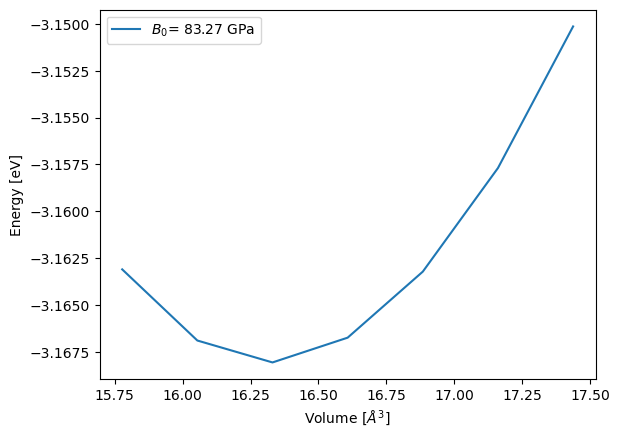

In [10]:
plt.plot(fit_dict["volume"], fit_dict["energy"], label="$B_0$= %0.2f GPa" % fit_dict["bulkmodul_eq"])
plt.xlabel("Volume [$\AA^3$]")
plt.ylabel("Energy [eV]")
plt.legend()

## FluxJobExecutor
In analogy to the [FluxClusterExecutor](https://executorlib.readthedocs.io/en/latest/2-hpc-cluster.html#flux) the [FluxJobExecutor](https://executorlib.readthedocs.io/en/latest/3-hpc-job.html#flux) can be applied to distribute simulation within a given queuing system allocation. The calculation of the bulk modulus with [gpaw](https://gpaw.readthedocs.io) is implemented in the same way.

In [11]:
from executorlib import FluxJobExecutor

The for each strained structure a calculation task is submitted to the `FluxJobExecutor`. After the successful submission the current status of the flux queue is printed using `flux jobs -a`. Finally, the results are collected by gathering the [concurrent.futures.Future](https://docs.python.org/3/library/concurrent.futures.html#future-objects) objects.

In [12]:
future_dict = {}
with FluxJobExecutor() as exe:
    for k, v in task_loop_dict.items():
        future_dict[k] = exe.submit(
            evaluate_with_gpaw, 
            task_dict=v, 
            kpts=(3, 3, 3), 
            encut=300,
            resource_dict={"cores": 2},
        )
    sleep(1)
    pprint.pp(subprocess.check_output(["flux", "jobs", "-a"], universal_newlines=True).split("\n"))
    result_dict = {
        k: f.result() 
        for k, f in tqdm(future_dict.items())
    }
    sleep(1)
    pprint.pp(subprocess.check_output(["flux", "jobs", "-a"], universal_newlines=True).split("\n"))

['       JOBID USER     NAME       ST NTASKS NNODES     TIME INFO',
 '    ƒe43yvxQ jovyan   python      R      2      1   4.126s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒe43yvxP jovyan   python      R      2      1   4.127s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒe42Vwg4 jovyan   python      R      2      1   4.127s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒe42Vwg3 jovyan   python      R      2      1   4.127s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒe411xPi jovyan   python      R      2      1   4.219s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒe411xPh jovyan   python      R      2      1   4.220s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒe3yXy7M jovyan   python      R      2      1   4.221s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒ5ug76VM jovyan   executorl+  F      2      1   1.187m '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒ4iiCWB1 jovyan   executorl+  F      2      1   1.213m '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒ3PybgBq jovyan   executor

100%|██████████| 7/7 [00:23<00:00,  3.35s/it]


['       JOBID USER     NAME       ST NTASKS NNODES     TIME INFO',
 '    ƒe43yvxQ jovyan   python      R      2      1   29.27s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒe43yvxP jovyan   python      R      2      1   29.27s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒe42Vwg4 jovyan   python      R      2      1   29.27s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒe42Vwg3 jovyan   python      R      2      1   29.27s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒe411xPi jovyan   python      R      2      1   29.27s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒe411xPh jovyan   python      R      2      1   29.27s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒe3yXy7M jovyan   python      R      2      1   29.27s '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒ5ug76VM jovyan   executorl+  F      2      1   1.187m '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒ4iiCWB1 jovyan   executorl+  F      2      1   1.213m '
 'jupyter-jan-janssen-exe-bq7jl2p3',
 '    ƒ3PybgBq jovyan   executor

Exception ignored in: <function SocketInterface.__del__ at 0x7e66a9fece50>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/executorlib/standalone/interactive/communication.py", line 179, in __del__
    self.shutdown(wait=True)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/executorlib/standalone/interactive/communication.py", line 158, in shutdown
    self._spawner.shutdown(wait=wait)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/executorlib/task_scheduler/interactive/spawner_flux.py", line 150, in shutdown
    self._future.result()
  File "/srv/conda/envs/notebook/lib/flux/python3.10/flux/job/executor.py", line 331, in result
    return super().result(*args, **kwargs)
  File "/srv/conda/envs/notebook/lib/python3.10/concurrent/futures/_base.py", line 458, in result
    return self.__get_result()
  File "/srv/conda/envs/notebook/lib/python3.10/concurrent/futures/_base.py", line 403, in __get_result
    raise

The resulting energies for the different volumes are fitted using a 3rd order polynomial to derive the bulk modulus as second derivative multiplied by the equilibrium volume.

In [13]:
fit_dict = analyse_results_for_energy_volume_curve(
    output_dict={"energy": result_dict},
    task_dict=task_dict,
    fit_type="polynomial",
    fit_order=3,
)

The final energy volume curve plot summarizes the results of this calculation.

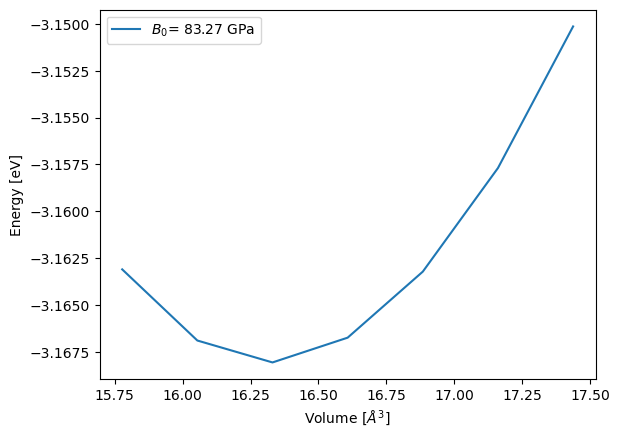

In [14]:
plt.plot(fit_dict["volume"], fit_dict["energy"], label="$B_0$= %0.2f GPa" % fit_dict["bulkmodul_eq"])
plt.xlabel("Volume [$\AA^3$]")
plt.ylabel("Energy [eV]")
plt.legend()